In [1]:
import numpy as np 
import pandas as pd 
import os
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis')
import analog
sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
from battery import OCVcurve, segment
from analog import logextract
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
log_path = '/home/lucas/Documents/Log_Analysis/Battery'
print(os.listdir(log_path))
file1 = f'{log_path}/2019-09-06_1_LiHV - Discharge-part1.csv'
file2 = f'{log_path}/2019-09-06_1_LiHV - Discharge-part2.csv'
file3 = f'{log_path}/2019-09-09_1_LiHV - Discharge-part3.csv'
file1_charge = f'{log_path}/2019-09-10_1_LiHV - Charge-part1.csv' 
file2_charge = f'{log_path}/2019-09-10_1_LiHV - Charge-part2.csv' 
file3_charge = f'{log_path}/2019-09-11_1_LiHV - Charge-part3.csv' 

['resistancetestz0.ulg', 'Battery Simulation.ipynb', 'Equivalent Circuit Parameters Estimation-z0.ipynb', 'Static parameters estimation.ipynb', 'SOCvsOCV.csv', 'log_297_2019-9-3-15-14-02.ulg', 'log_296_2019-9-3-15-11-56.ulg', 'motor_test_compressed.txt', 'Rough EC Dynamic Params Estimation.ipynb', 'log_119_variancetest.ulg', '.ipynb_checkpoints', 'log_299_2019-9-3-15-22-14.ulg', '2019-09-09_1_LiHV - Discharge-part3.csv', 'battery_test_compressed.txt', 'motor_test.log', '2019-09-06_1_LiHV - Discharge-part1.csv', '2019-09-11_1_LiHV - Charge-part3.csv', 'battery.py', 'SOC estimator couloumb counting.ipynb', 'EC dynamic parameters estimation.ipynb', 'log_298_2019-9-3-15-24-50.ulg', '2019-09-06_1_LiHV - Discharge-part2.csv', '2019-09-10_1_LiHV - Charge-part1.csv', 'log_295_2019-9-3-15-07-46.ulg', '2019-09-10_1_LiHV - Balance-Charge-part1.csv', 'Q200', '__pycache__', '2019-09-10_1_LiHV - Charge-part2.csv', 'Voltage sensor variance estimation.ipynb', 'battery_test.log', 'log_120_variancetest.

In [3]:
seg1 = segment(path2csv=file1,mode='discharge')
seg2 = segment(path2csv=file2,mode='discharge')
seg3 = segment(path2csv=file3,mode='discharge')

In [4]:
seg1_charge = segment(path2csv=file1_charge,mode='charge')
seg2_charge = segment(path2csv=file2_charge,mode='charge')
seg3_charge = segment(path2csv=file3_charge,mode='charge')

In [5]:
print(seg1_charge.cell_voltage)
print(seg2_charge.cell_voltage)
print(seg3_charge.cell_voltage)

0      3.388
1      3.392
2      3.388
3      3.390
4      3.389
       ...  
663    3.401
664    3.396
665    3.398
666    3.401
667    3.398
Name: CellVoltage 1 [V], Length: 668, dtype: float64
0         3.388
1         3.392
2         3.388
3         3.390
4         3.389
          ...  
112381    3.694
112382    3.693
112383    3.696
112384    3.692
112385    3.691
Name: CellVoltage 1 [V], Length: 112386, dtype: float64
0         3.696
1         3.693
2         3.692
3         3.699
4         3.692
          ...  
607687    4.352
607688    4.352
607689    4.353
607690    4.350
607691    4.355
Name: CellVoltage 1 [V], Length: 607692, dtype: float64


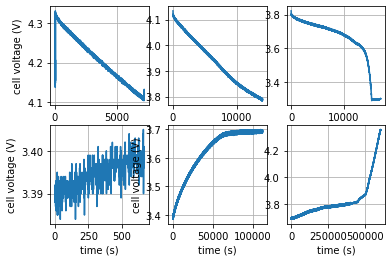

In [6]:
plt.figure()
plt.subplot(231)
seg1.vplot()
plt.ylabel('cell voltage (V)')

plt.subplot(232)
seg2.vplot()

plt.subplot(233)
seg3.vplot()

plt.subplot(234)
seg1_charge.vplot()
plt.xlabel('time (s)')
plt.ylabel('cell voltage (V)')

plt.subplot(235)
seg2_charge.vplot()
plt.xlabel('time (s)')
plt.ylabel('cell voltage (V)')

plt.subplot(236)
seg3_charge.vplot()
plt.xlabel('time (s)')
plt.show()

In [7]:
discharge = seg1.concatenate(seg2.concatenate(seg3))

In [8]:
charge = seg1_charge.concatenate(seg2_charge.concatenate(seg3_charge))

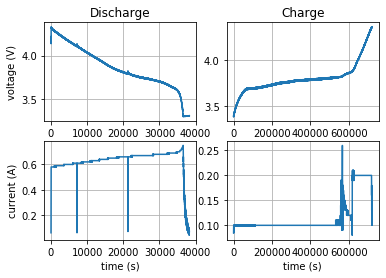

discharge


In [9]:
plt.figure()
plt.subplot(221)
discharge.vplot(label='discharge')
plt.ylabel('voltage (V)')
plt.title('Discharge')
plt.subplot(222)
charge.vplot(label='charge')
plt.title('Charge')
plt.subplot(223)
discharge.cplot(label='discharge')
plt.xlabel('time (s)')
plt.ylabel('current (A)')

plt.subplot(224)
charge.cplot(label='charge')
plt.xlabel('time (s)')
plt.show()

print(discharge.mode)

In [10]:
charge.count_charge(0)
discharge.count_charge(1)

print(f'Total discharge capacity is {round(discharge.Q/3.6,2)} mAh')
print(f'Total charge capacity is {round(charge.Q/3.6,2)} mAh')
eta = discharge.Q/charge.Q
print(eta)

Total discharge capacity is 6671.87 mAh
Total charge capacity is 23359.33 mAh
0.2856192691307477


<IPython.core.display.Javascript object>


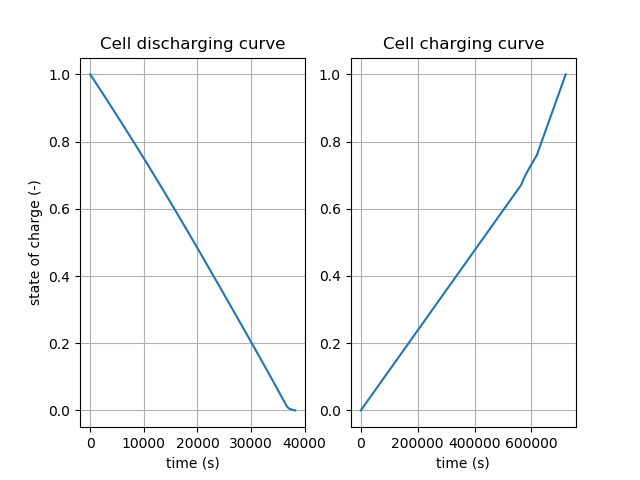

In [18]:
%matplotlib notebook
plt.figure()
plt.subplot(121)
discharge.zplot()
plt.xlabel('time (s)')
plt.ylabel('state of charge (-)')
plt.title('Cell discharging curve')
plt.subplot(122)
charge.zplot()
plt.xlabel('time (s)')
plt.title('Cell charging curve')
plt.show()

In [12]:
charge_OCV = OCVcurve()
charge_OCV.fromsegment(charge)
discharge_OCV = OCVcurve()
discharge_OCV.fromsegment(discharge)

R0 = 0.0123
charge_OCV.intrescorr(R0)
discharge_OCV.intrescorr(R0)

In [13]:
print(charge_OCV.SOC)

0         0.000000
1         0.000001
2         0.000002
3         0.000004
4         0.000005
            ...   
720741    0.999994
720742    0.999996
720743    0.999997
720744    0.999999
720745    1.000000
Length: 720746, dtype: float64


<IPython.core.display.Javascript object>


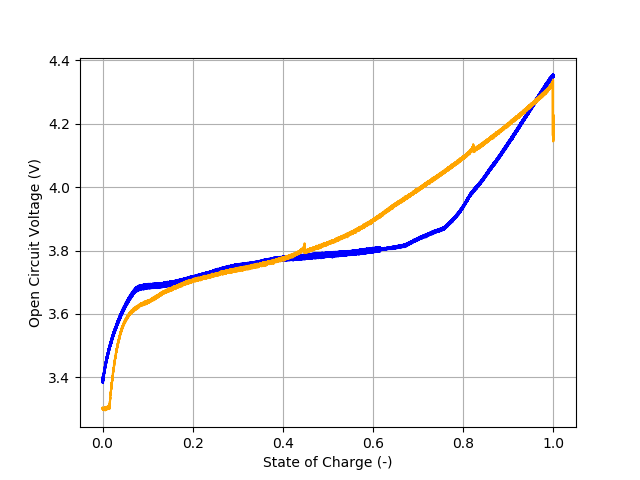

In [17]:
plt.figure()
charge_OCV.plot()
discharge_OCV.plot(color='orange')
plt.grid()

In [15]:
p = np.polyfit([charge_OCV.SOC,discharge_OCV.SOC],[],11)
#p = np.polyfit(z[:-2000],OCV[:-2001],11)
print(z.iloc[-1500])

NameError: name 'z' is not defined

In [ ]:
plt.figure()
plt.plot(z,cell_voltage[1:],label='measured')
plt.plot(z,OCV[1:],linestyle='--',label='without R0')
plt.plot(z,np.polyval(p,z),label='polynomial')
plt.legend()
plt.grid()
plt.xlabel('State of Charge (-)')
plt.ylabel('OCV (V)')

In [ ]:
import csv 
csv_file = open('SOCvsOCV.csv','w')
writer = csv.writer(csv_file)
writer.writerow(['SOC','OCV'])
for k in range(len(z)):
    writer.writerow([z.values[k],np.polyval(p,z.values[k])])

In [ ]:
plt.figure()
plt.plot(stime_charge,z_charge)

In [ ]:
x = pd.Series(1)
print(x)

In [ ]:
x.append(1 -charge.dq)